# Diabetes Model Training, Evaluation, and External Validation

This notebook provides a comprehensive workflow for the Diabetes prediction system:
1. **Training**: Evaluates 5 different machine learning algorithms.
2. **Internal Testing**: Detailed performance metrics and confusion matrices.
3. **Cross-Validation**: Ensuring model robustness.
4. **External Validation**: Testing against the Albukhary dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from imblearn.over_sampling import SMOTE
import joblib
import os

print('Libraries imported successfully!')
sns.set_style('whitegrid')

Libraries imported successfully!


## 1. Load and Clean Dataset

In [2]:
ML_PATH = 'predictions/ml'
CSV_PATH = os.path.join(ML_PATH, 'diabetes.csv')

df = pd.read_csv(CSV_PATH)
print(f'Dataset shape: {df.shape}')

# Impute zero values with median
zero_impute_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for col in zero_impute_cols:
    if col in df.columns:
        median_val = df[df[col] != 0][col].median()
        df[col] = df[col].replace(0, median_val)

# Select core features
df = df[['Age', 'BMI', 'BloodPressure', 'Glucose', 'Outcome']]
X = df.drop('Outcome', axis=1)
y = df['Outcome']
print(f'Using features: {X.columns.tolist()}')

Dataset shape: (768, 9)
Using features: ['Age', 'BMI', 'BloodPressure', 'Glucose']


## 2. Train-Test Split and Class Balancing

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)

# Apply SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# Scaling
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

print(f'Original Class Dist: {y_train.value_counts().to_dict()}')
print(f'Balanced Class Dist: {y_train_res.value_counts().to_dict()}')

Original Class Dist: {0: 392, 1: 222}
Balanced Class Dist: {0: 392, 1: 392}


## 3. Algorithm Comparison and Cross-Validation

In [4]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=3),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Support Vector Machine': SVC(random_state=42, probability=True),
}

print('Running 5-Fold Cross-Validation...')
cv_results = {}
for name, model in models.items():
    scores = cross_val_score(model, X_train_scaled, y_train_res, cv=5)
    cv_results[name] = scores.mean()
    print(f'{name}: {scores.mean():.4f}')

print('\nTesting on Hold-out Set...')
test_results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train_res)
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    test_results[name] = acc
    print(f'{name}: {acc:.4f}')

Running 5-Fold Cross-Validation...
Logistic Regression: 0.7398


K-Nearest Neighbors: 0.7934
Decision Tree: 0.7845


Random Forest: 0.8253


Support Vector Machine: 0.7909

Testing on Hold-out Set...
Logistic Regression: 0.7403
K-Nearest Neighbors: 0.7208
Decision Tree: 0.7273
Random Forest: 0.7338


Support Vector Machine: 0.7273


## 4. Evaluation (Confusion Matrices)

Best Model: Logistic Regression
              precision    recall  f1-score   support

           0       0.89      0.72      0.80       108
           1       0.55      0.78      0.64        46

    accuracy                           0.74       154
   macro avg       0.72      0.75      0.72       154
weighted avg       0.78      0.74      0.75       154



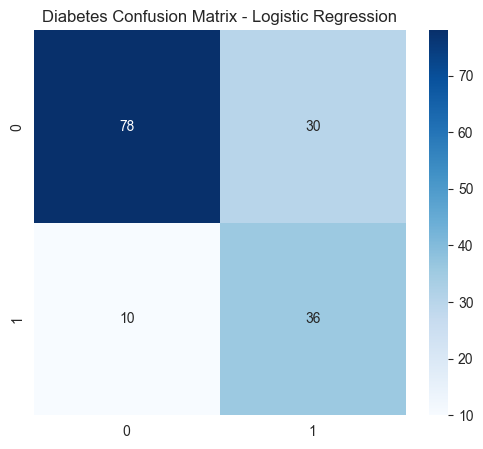

In [5]:
best_name = max(test_results, key=test_results.get)
best_model = models[best_name]
y_pred = best_model.predict(X_test_scaled)

print(f'Best Model: {best_name}')
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Diabetes Confusion Matrix - {best_name}')
plt.show()

## 5. External Validation (Albukhary Dataset)

In [6]:
print('Loading External Albukhary Dataset...')
try:
    ext_df = pd.read_excel('predictions/ml/test_dataset.xlsx')
    print(f'Loaded {len(ext_df)} rows.')
    
    true_labels = []
    pred_labels = []
    
    for _, row in ext_df.iterrows():
        glucose = row['Glucose']
        age = row['Age']
        bmi = row['BMI']
        
        # Unit Conversion Heuristic
        if pd.notna(glucose) and glucose < 50:
            glucose = glucose * 18.0182
            
        # Clinical Ground Truth Assumption
        clinical_truth = "Positive" if glucose >= 140 else "Negative"
        
        # BP Extraction
        bp_raw = row['Blood Pressure']
        bp = None
        if isinstance(bp_raw, str) and '/' in bp_raw:
            bp = float(bp_raw.split('/')[1])
        elif pd.notna(bp_raw): bp = float(bp_raw)
        
        if not any(pd.isna([age, bmi, bp, glucose])):
            # ML Prediction
            feat = np.array([[age, bmi, bp, glucose]])
            feat_sc = scaler.transform(feat)
            ml_pred = "Positive" if best_model.predict(feat_sc)[0] == 1 else "Negative"
            
            true_labels.append(clinical_truth)
            pred_labels.append(ml_pred)
            
    print('\nExternal Validation Metrics (Albukhary):')
    print(f'Accuracy: {accuracy_score(true_labels, pred_labels):.2%}')
    print(classification_report(true_labels, pred_labels))
    
except Exception as e:
    print(f'Could not run external validation: {e}')

Loading External Albukhary Dataset...


Loaded 16 rows.

External Validation Metrics (Albukhary):
Accuracy: 87.50%
              precision    recall  f1-score   support

    Negative       1.00      0.83      0.91        12
    Positive       0.67      1.00      0.80         4

    accuracy                           0.88        16
   macro avg       0.83      0.92      0.85        16
weighted avg       0.92      0.88      0.88        16



C:\Users\modou\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
C:\Users\modou\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
C:\Users\modou\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
C:\Users\modou\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
C:\Users\modou\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RobustScal